# Load the data in the form of a dictionary

# The dictionary has different keys
- DESCR:  describes the dataset
- data: array of data (one row per instance, one column per feature)
- target: array of labels
...

In [54]:
!pip install scikit-learn
!pip install pandas
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1) # Returns a dictionary with the data
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

# Get the data and labels

In [55]:

import numpy as np
X, y = mnist["data"], mnist["target"]
y = y.astype(int) # Convert y to list of integers
X = ((X/255.) - .5)*2
print(X.shape, y.shape)
print(min(y),max(y))
print(type(X), type(y))
print(np.min(np.min(X,axis=0),axis=0),np.max(np.max(X,axis=0)))

(70000, 784) (70000,)
0 9
<class 'pandas.core.frame.DataFrame'> <class 'pandas.core.series.Series'>
-1.0 1.0


# Visualize the data

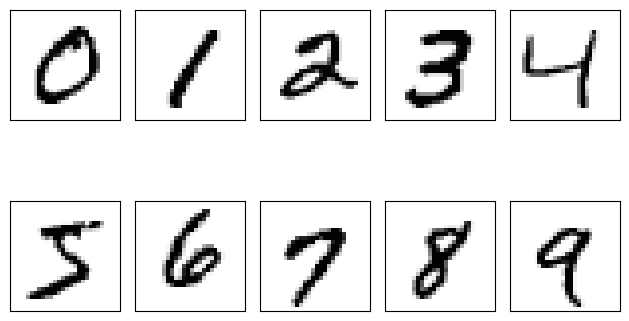

In [56]:
import matplotlib as mpl
import matplotlib.pyplot as plt
fig, ax = plt.subplots(nrows=2, ncols=5,sharex=True, sharey=True)
ax = ax.flatten()
for i in range(10):
    matchlist = [i for i, x in enumerate(y == i) if x]
    img = X.loc[matchlist[0]].to_numpy().reshape(28,28)
    ax[i].imshow(img,cmap='Greys')
ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.show()

# Divide the data into training, development and testing sets

In [57]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
print(min(y_train),max(y_train))
print(min(y_test),max(y_test))
X_test = X_test.to_numpy()
y_test  = y_test .to_numpy()

(60000, 784) (10000, 784) (60000,) (10000,)
0 9
0 9


In [58]:
from sklearn.model_selection import StratifiedShuffleSplit

splitter=StratifiedShuffleSplit(n_splits=1,random_state=12)
for train,test in splitter.split(X_train,y_train):
    X_train_strat = X_train.iloc[train]
    y_train_strat  = y_train.iloc[train]
    X_dev_strat= X_train.iloc[test]
    y_dev_strat = y_train.iloc[test]
X_train_strat = X_train_strat.to_numpy()
y_train_strat = y_train_strat.to_numpy()
X_dev_strat = X_dev_strat.to_numpy()
y_dev_strat = y_dev_strat.to_numpy()
#print(X_train_strat.shape, y_train_strat.shape, X_dev_strat.shape, y_dev_strat.shape)
#print(min(y_train_strat),max(y_train_strat))
#print(min(y_dev_strat),max(y_dev_strat))


# Use the dataloader to automatically divide data into batches

In [59]:
# Import key libraries
import torch
import torch.nn as nn
import torch.nn.functional as Func
from torch.autograd import Variable
import torch.optim as optim
import torch.utils.data as data
import random
from scipy.io import savemat
import os
from os import path
from sklearn.preprocessing import normalize
from torch.nn.utils import clip_grad_norm_
import torch.nn.parallel.data_parallel as data_parallel
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

In [60]:
# Define key hyperparameters
class hyperparam:
    num_classes    = 10 # 10 neurons for the output layer
    input_dim      = 28*28 # Inputs are size 28x28
    lr          = 0.05 # Initial learning rate
    num_epochs = 100 # Number of epochs
    bs          = 50 # Mini-batch size


In [61]:
class myDataset(data.Dataset):
    def __init__(self, input_data, labels):
        # Initialize variables
        self.feats = input_data
        self.labels = labels

    def __len__(self):
        return len(self.labels) # returns the number of samples

    def __getitem__(self, index): # Returns sample data and label
        # Reshaping inputs to size 28x28
        X = self.feats[index].reshape(28, 28)
        X = X[np.newaxis, :, :]
        X = torch.tensor(X, dtype = torch.float32)
        y = torch.tensor(self.labels[index], dtype=torch.long)
        return X, y


In [62]:
params = {'batch_size': hyperparam.bs,
         'shuffle': True,
         'num_workers': 0,
         'drop_last': False,
         'pin_memory': False}

training_set = myDataset(X_train_strat,y_train_strat)
dev_set      = myDataset(X_dev_strat,y_dev_strat)
test_set     = myDataset(X_test,y_test)

training_gen = data.DataLoader(training_set,**params)
dev_gen      = data.DataLoader(dev_set,**params)

params2 = {'batch_size': 16,
         'shuffle': False,
         'num_workers': 0,
         'drop_last': False,
         'pin_memory': False}
testing_gen  = data.DataLoader(test_set,**params2)
print(X_train_strat.shape)

(54000, 784)


In [63]:
import torch.nn.functional as F

# Define the Neural Network

In [64]:
class DNN(nn.Module):
    def __init__(self):
        super(DNN,self).__init__()

        self.conv1 = nn.Conv2d(in_channels = 1, out_channels = 6, kernel_size = 3, stride = 1) # Convolutional layer 1 with 6 3x3 kernels and stride = 1
        self.conv2 = nn.Conv2d(in_channels = 6, out_channels = 10, kernel_size = 3, stride = 1) # Convolutional layer 2 with 10 3x3 kernels and stride = 1
        new_dimension = 10 * 24 * 24 # Dimension after convolution
        self.output = nn.Linear(new_dimension, 10) # 10 neurons for the output layer

    def forward(self,sig):
        sig = self.conv1(sig) # Convolution 1
        sig = F.relu(sig) # Followed by ReLU A.F.
        sig = self.conv2(sig) # Convolution 2
        sig = F.relu(sig) # Followed by ReLU A.F.
        sig = sig.view(sig.size(0),-1) # Flattening
        sig = self.output(sig) # nn.Linear
        return sig


In [65]:
# Create DNN and define loss function
dnn_model = DNN()
optimizer = torch.optim.SGD(dnn_model.parameters(), lr=hyperparam.lr)
# Cross-entropy loss function
loss = nn.CrossEntropyLoss()

In [66]:
%autosave 0

Autosave disabled


In [67]:
# Baseline system should use Xavier initialization based on uniform distribution
def xavier(module_weights):
    if isinstance(module_weights, (nn.Conv2d, nn.Linear)):
        torch.nn.init.xavier_uniform_(module_weights.weight)
dnn_model.apply(xavier)

DNN(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 10, kernel_size=(3, 3), stride=(1, 1))
  (output): Linear(in_features=5760, out_features=10, bias=True)
)

In [40]:
# Mini-batch GD with momentum (beta = 0.9) & mini batch size of 50
optimizer = torch.optim.SGD(dnn_model.parameters(), lr=0.05, momentum=0.9)
# A learning rate scheduler to adjust the learning rate by 10% every 10 epochs, starting with a learning rate of 0.05
learning_rate = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.9)

In [68]:
# Early stopping
epoch_step = 10
best_dev_loss = 0
early_stop = 0

In [69]:
# Train the DNN
import warnings
warnings.filterwarnings('ignore')
tr_avgLoss_list = [] # Avg. training loss per epoch
tr_accuracy_list = [] # Training accuracy per epoch
dev_avgLoss_list = [] # Avg. validation loss per epoch
dev_accuracy_list = [] # Validation accuarcy per epoch

# Loop over epochs
for epoch in range(hyperparam.num_epochs):
    tr_num_correct = 0 # Num. correctly classified training samples
    tr_num_samples = 0 # Total number of training samples
    tr_total_loss = 0.0 # Total training loss

    dev_num_correct = 0 # Num. correctly classified validation samples
    dev_num_samples = 0 # Total number of validation samples
    dev_total_loss = 0.0 # Total validaton loss

    # Training
    dnn_model.train(True)

    with torch.set_grad_enabled(True):
        for local_batch, local_labels in training_gen:

            optimizer.zero_grad()

            local_batch = local_batch.float()
            local_labels = local_labels.float()
            local_batch, local_labels = Variable(local_batch), Variable(local_labels)

            # Model computations
            out1 = dnn_model(local_batch)
            #CrossEntropy loss calculation
            pLoss = loss(out1,local_labels.long())
            tr_total_loss += pLoss.item()*hyperparam.bs #Correct for average based on batch size

            # Backpropagation
            pLoss.backward() #gradient calculation
            optimizer.step() #weight update


            sel_class = torch.argmax(out1,dim=1)

            tr_num_correct += sel_class.eq(local_labels).sum().item()
            tr_num_samples += hyperparam.bs

        tr_avgLoss = tr_total_loss/len(training_gen.dataset)
        tr_avgLoss_list.append(tr_avgLoss)

        tr_accuracy = tr_num_correct/tr_num_samples
        tr_accuracy_list.append(tr_accuracy)

    # Validation
    with torch.set_grad_enabled(False):
        dnn_model.eval()

        for local_batch, local_labels in dev_gen:

            local_batch = local_batch.float()
            local_labels = local_labels.float()
            local_batch, local_labels = Variable(local_batch), Variable(local_labels)

            # Model computations
            out1 = dnn_model(local_batch)

            #CrossEntropy loss calculation
            pLoss = loss(out1,local_labels.long())
            dev_total_loss += pLoss*hyperparam.bs #Correct for average based on batch size

            sel_class = torch.argmax(out1,dim=1)

            dev_num_correct += sel_class.eq(local_labels).sum().item()
            #print(correction)
            dev_num_samples += hyperparam.bs

        dev_avgLoss = dev_total_loss/len(dev_gen.dataset)
        dev_avgLoss_list.append(dev_avgLoss)

        dev_accuracy = dev_num_correct/dev_num_samples
        dev_accuracy_list.append(dev_accuracy)

        learning_rate.step()

        print('Epoch {:2}, Train Loss: {:>.9f}, Train Accuracy: {:>.5f}, Dev Loss: {:>.9f}, Dev Accuracy: {:>.5f}'.format(epoch,tr_avgLoss,tr_accuracy,dev_avgLoss,dev_accuracy))

        if dev_avgLoss < best_dev_loss:
            best_dev_loss = dev_avgLoss
            early_stop = 0
        else:
            early_stop += 1
        if early_stop >= epoch_step:
            print(f"Early stopped at epoch {epoch +1}")
            break


Epoch  0, Train Loss: 0.225637245, Train Accuracy: 0.93119, Dev Loss: 0.098015189, Dev Accuracy: 0.96967
Epoch  1, Train Loss: 0.088589555, Train Accuracy: 0.97344, Dev Loss: 0.074466906, Dev Accuracy: 0.97767
Epoch  2, Train Loss: 0.065345741, Train Accuracy: 0.98041, Dev Loss: 0.067390181, Dev Accuracy: 0.97933
Epoch  3, Train Loss: 0.053529438, Train Accuracy: 0.98337, Dev Loss: 0.060235403, Dev Accuracy: 0.98200
Epoch  4, Train Loss: 0.045268128, Train Accuracy: 0.98598, Dev Loss: 0.054491434, Dev Accuracy: 0.98383
Epoch  5, Train Loss: 0.038126434, Train Accuracy: 0.98783, Dev Loss: 0.054970331, Dev Accuracy: 0.98333
Epoch  6, Train Loss: 0.033089207, Train Accuracy: 0.98950, Dev Loss: 0.053542353, Dev Accuracy: 0.98517
Epoch  7, Train Loss: 0.028520612, Train Accuracy: 0.99146, Dev Loss: 0.050434820, Dev Accuracy: 0.98517
Epoch  8, Train Loss: 0.023896137, Train Accuracy: 0.99280, Dev Loss: 0.053300019, Dev Accuracy: 0.98267
Epoch  9, Train Loss: 0.021565541, Train Accuracy: 0.99

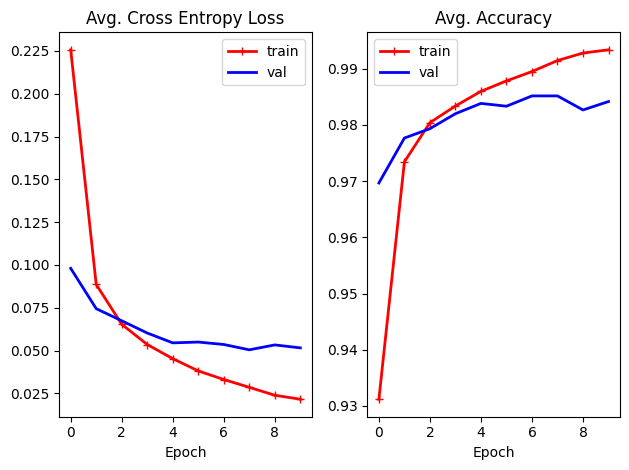

In [70]:
# Outcomes (1): Generate learning curves for the validation and testing sets.
fig, ax = plt.subplots(nrows=1, ncols=2,sharex=False, sharey=False)
ax = ax.flatten()
tr_errors = [tr_avgLoss_list, tr_accuracy_list]
dev_errors = [dev_avgLoss_list, dev_accuracy_list]
er_title = ['Avg. Cross Entropy Loss','Avg. Accuracy']
for i in range(2):
    ax[i].plot(tr_errors[i],"r-+",linewidth=2, label ="train")
    ax[i].plot(dev_errors[i],"b-",linewidth=2,label ="val")
    ax[i].legend()
    ax[i].title.set_text(er_title[i])
    ax[i].set_xlabel('Epoch')

plt.tight_layout()
plt.show()

Outcomes (1) Discussion: As the number of epochs increases, the average cross entropy loss decreases for both the training and validation data, but decreases even more for the training data after around the second epoch while it steadily plateaus a bit for the validation data. Furthermore, as the number of epochs increases, the average accuracy increases for both the training and validation data, but increases even more for the training data after around the second epoch. While both have low average cross entropy loss and high average accuracy, this is a sign that there is some overfitting occuring here with the baseline model and the baseline model could improve in generalizing better to unseen data.

In [71]:
# Outcomes (2): Test this baseline system with the testing data and report the
# accuracy and show a confusion matrix.

actuals = []
predicted = []

test_total_loss=0.0
test_num_correct =0
with torch.set_grad_enabled(False):
    dnn_model.eval()

    for local_batch, local_labels in testing_gen:

            local_batch = local_batch.float()
            local_labels = local_labels.float()
            local_batch, local_labels = Variable(local_batch), Variable(local_labels)

            # Model computations
            out1 = dnn_model(local_batch)
            predictions = torch.argmax(out1, dim=1)
            predicted.extend(predictions.detach().numpy())
            actuals.extend(local_labels.detach().numpy())

            #CrossEntropy loss calculation
            pLoss = loss(out1,local_labels.long())
            test_total_loss += pLoss*1 #Correct for average based on batch size

            sel_class = torch.argmax(out1,dim=1)

            test_num_correct += sel_class.eq(local_labels.long()).sum().item() #Added .long()
            test_num_samples = len(testing_gen.dataset)

    test_avgLoss = test_total_loss/len(testing_gen.dataset)
    test_accuracy = test_num_correct/test_num_samples

    print('Test Loss: {:>.9f}, Test Accuracy: {:>.5f}'.format(test_avgLoss,test_accuracy))
    print(confusion_matrix(actuals, predicted))


Test Loss: 0.003465664, Test Accuracy: 0.98460
[[ 975    0    1    0    1    0    1    1    1    0]
 [   1 1127    4    1    1    0    0    1    0    0]
 [   2    3 1015    1    2    0    0    8    1    0]
 [   0    0    3 1001    0    4    0    1    1    0]
 [   0    0    1    0  973    0    1    0    3    4]
 [   2    0    2    7    0  880    1    0    0    0]
 [   8    3    0    1    3    9  933    0    1    0]
 [   0    1    5    2    1    0    0 1017    1    1]
 [   5    0    3    2    0    2    3    3  954    2]
 [   6    2    0    4   11    5    0    7    3  971]]


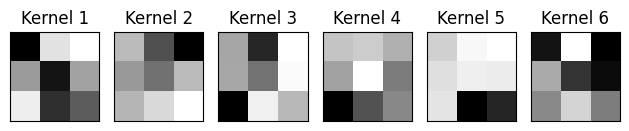

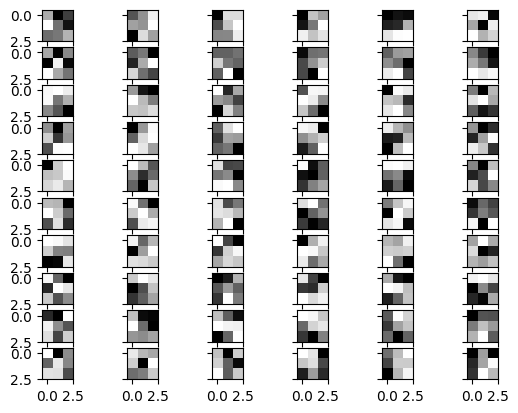

In [53]:
# Outcomes (3): Display a subset of the kernels from each convolutional layer as
# images (e.g. using matplotlib, subplot, imshow).

# Convolutional layer 1:
weights1 = dnn_model.conv1.weight.data.numpy()
filters1 = weights1.shape[0]

fig, ax = plt.subplots(nrows=1, ncols=filters1,sharex=True, sharey=True)
ax = ax.flatten()
for i in range(filters1):
    img = weights1[i].reshape(3,3)
    ax[i].imshow(img,cmap='Grays')
    ax[i].set_title(f'Kernel {i+1}')
ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.show()

# Convolutional layer 2:
weights2 = dnn_model.conv2.weight.data.numpy()
filters2 = weights2.shape[0]
channels2 = weights2.shape[1]

fig, ax = plt.subplots(nrows = filters2, ncols=channels2,sharex=True, sharey=True)
ax = ax.flatten()
for i in range(filters2):
    for j in range(channels2):
        img = weights2[i,j].reshape(3,3)
        ax[i*channels2+j].imshow(img,cmap='Grays')


Outcomes (3) cont: Discuss the kernels and what patterns it seems like they may be learning, if any:

There do not appear to be any clear patterns with these kernels for both Convolution 1 and Convolution 2. Darker elements of the kernels are likely doing some kind of edge detection or sharpening while lighter elements of the kernels are likely doing some kind of smoothing or light intensity enhancement.

While I do not see any clear patterns amongst all 66 of these kernels, to interpret one of them, taking a look at "Kernel 4", it has a white center and darker surroundings, meaning attention is likely being drawn to the center pixel.